In [2]:
!pip config --user set global.progress_bar off

Writing to /root/.config/pip/pip.conf


In [ ]:
!pip install pycaret --upgrade
!pip install dabl --upgrade
!pip install shap --upgrade
!pip install sdv 
!pip install sdv[ctgan]
!pip install baytune --upgrade

#PYCARET

In [5]:
from pycaret.classification import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sdv.tabular import GaussianCopula, CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from sklearn.model_selection import train_test_split # Data split

In [6]:
hr_data = pd.read_csv("HR Employee Attrition.csv")

In [7]:
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [4]:
# Create GaussianCopula model for synthetic data
# - Set each feature to "bounded" distribution
model = GaussianCopula(primary_key = "EmployeeNumber",
                       field_distributions = {"DistanceFromHome" : "bounded",
                                              "HourlyRate": "bounded",  
                                              "DailyRate": "bounded",
                                              "MonthlyIncome": "bounded",
                                              "MonthlyRate": "bounded",
                                              "NumCompaniesWorked": "bounded", 
                                              "PercentSalaryHike": "bounded",
                                              "TotalWorkingYears": "bounded", 
                                              "YearsAtCompany": "bounded",
                                              "YearsWithCurrManager": "bounded", 
                                              "TrainingTimesLastYear": "gaussian", 
                                              "YearsSinceLastPromotion": "bounded",
                                              "StockOptionLevel" : "bounded",
                                              "EnvironmentSatisfaction" : "bounded",
                                              "JobInvolvement" : "bounded",
                                              "JobSatisfaction" : "bounded",
                                              "Education" : "bounded",
                                              "PerformanceRating" : "bounded",
                                              "RelationshipSatisfaction" : "bounded",
                                              "WorkLifeBalance" : "bounded",
                                              "BusinessTravel": "bounded",
                                              "Department" : "bounded", 
                                              "EducationField" : "bounded",
                                              "JobRole" : "bounded",
                                              "Gender" : "bounded",
                                              "JobLevel" : "bounded", 
                                              "JobRole" : "bounded", 
                                              "Over18" : "bounded",
                                              "MaritalStatus" : "bounded", 
                                              "OverTime" : "bounded", 
                                              "WorkLifeBalance" : "bounded"},
                       field_transformers = {"Gender" : "categorical",
                                              "Over18" : "categorical",
                                              "OverTime" : "categorical"})

In [ ]:
# Fit model
model.fit(hr_data[hr_data["Attrition"] == "Yes"])

# Generate synthetic data
synth_data = model.sample(250, max_retries = 300)

# Evalutate synthetic data vs real data
evaluate(synth_data, hr_data)

0.7305747352531817

In [33]:
from btb import BTBSession
from btb.tuning import Tunable, GCPTuner
from btb.tuning import hyperparams as hp 

In [9]:
hr_data = pd.read_csv("HR Employee Attrition.csv")

In [34]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 24, max = 300),
          'batch_size' : hp.IntHyperParam(min = 1, max = 30, include_min = True, include_max = True),
        }))

In [41]:
test = tuner.propose(1)
test['batch_size'] * 10, test

(90, {'batch_size': 9, 'epochs': 274})

In [44]:
best_score = 0

for _ in range(10):
  hr_data = pd.read_csv("HR Employee Attrition.csv")
  proposal = tuner.propose()
  model = CopulaGAN(batch_size = proposal['batch_size'] * 10,
                      epochs = proposal['epochs'],
                      primary_key = "EmployeeNumber",
                      field_distributions = {"DistanceFromHome" : "bounded",
                                            "HourlyRate": "bounded",  
                                            "DailyRate": "bounded",
                                            "MonthlyIncome": "bounded",
                                            "MonthlyRate": "bounded",
                                            "NumCompaniesWorked": "bounded", 
                                            "PercentSalaryHike": "bounded",
                                            "TotalWorkingYears": "bounded", 
                                            "YearsAtCompany": "bounded",
                                            "YearsWithCurrManager": "bounded", 
                                            "TrainingTimesLastYear": "gaussian", 
                                            "YearsSinceLastPromotion": "bounded",
                                            "StockOptionLevel" : "bounded",
                                            "EnvironmentSatisfaction" : "bounded",
                                            "JobInvolvement" : "bounded",
                                            "JobSatisfaction" : "bounded",
                                            "Education" : "bounded",
                                            "PerformanceRating" : "bounded",
                                            "RelationshipSatisfaction" : "bounded",
                                            "WorkLifeBalance" : "bounded",
                                            "BusinessTravel": "bounded",
                                            "Department" : "bounded", 
                                            "EducationField" : "bounded",
                                            "JobRole" : "bounded",
                                            "Gender" : "bounded",
                                            "JobLevel" : "bounded", 
                                            "JobRole" : "bounded", 
                                            "Over18" : "bounded",
                                            "MaritalStatus" : "bounded", 
                                            "OverTime" : "bounded", 
                                            "WorkLifeBalance" : "bounded"},
                      field_transformers = {"Gender" : "categorical",
                                            "Over18" : "categorical",
                                            "OverTime" : "categorical"})
  model.fit(hr_data[hr_data["Attrition"] == "Yes"])
  synth_data = model.sample(10, max_retries = 100)
  score = evaluate(synthetic_data = synth_data, real_data = hr_data)
  if score > best_score:
    best_params = proposal
    best_score = score
        
  tuner.record(proposal, score)
    
print('Best score obtained: ', best_score)
print('Best parameters: ', best_params)

AssertionError: ignored

Target looks like classification
Linear Discriminant Analysis training set score: 0.500


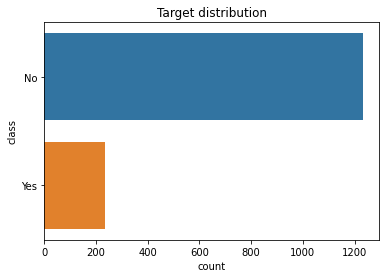

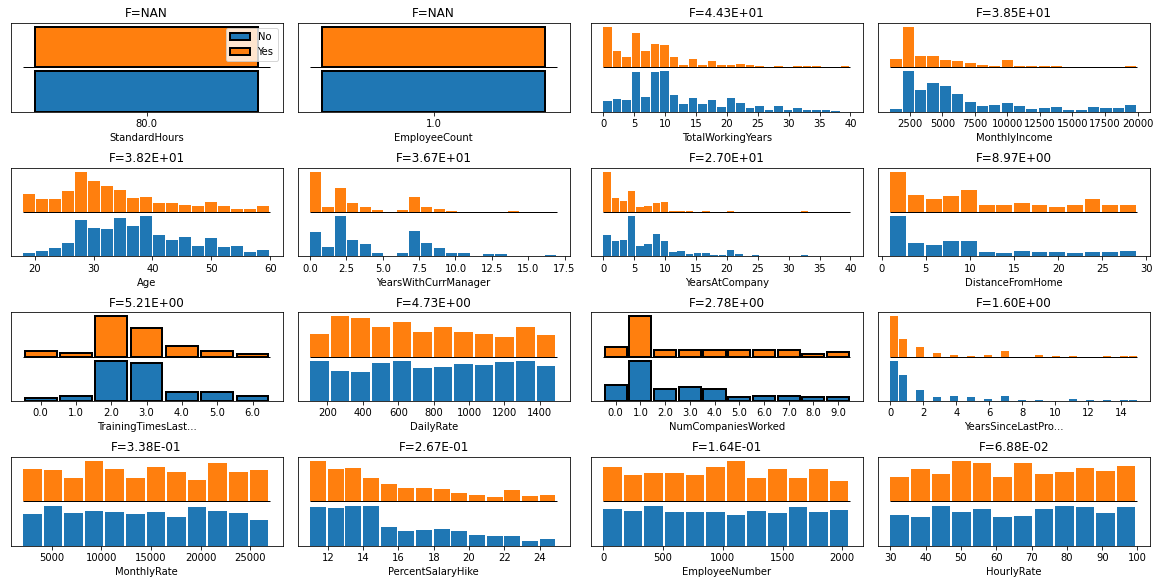

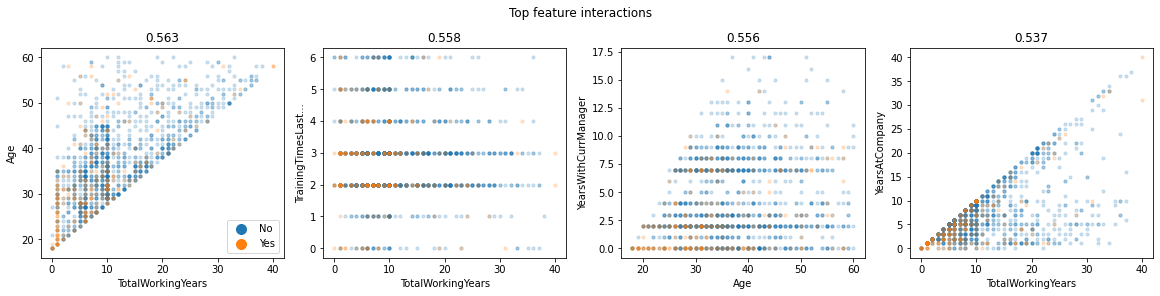

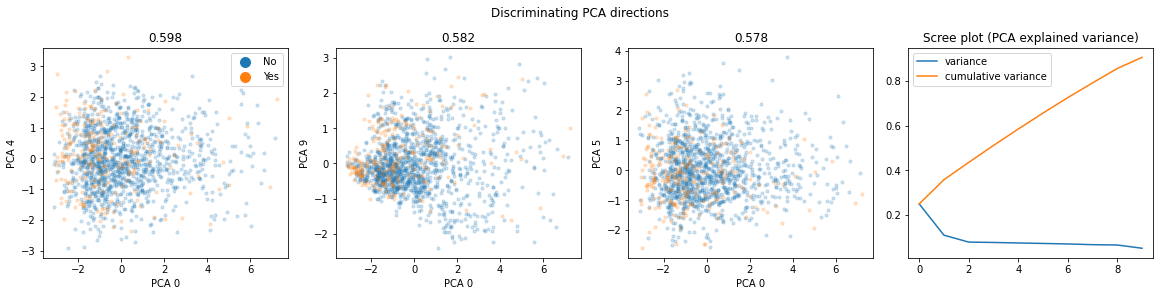

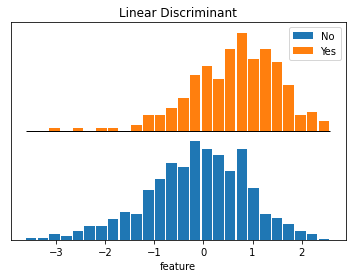

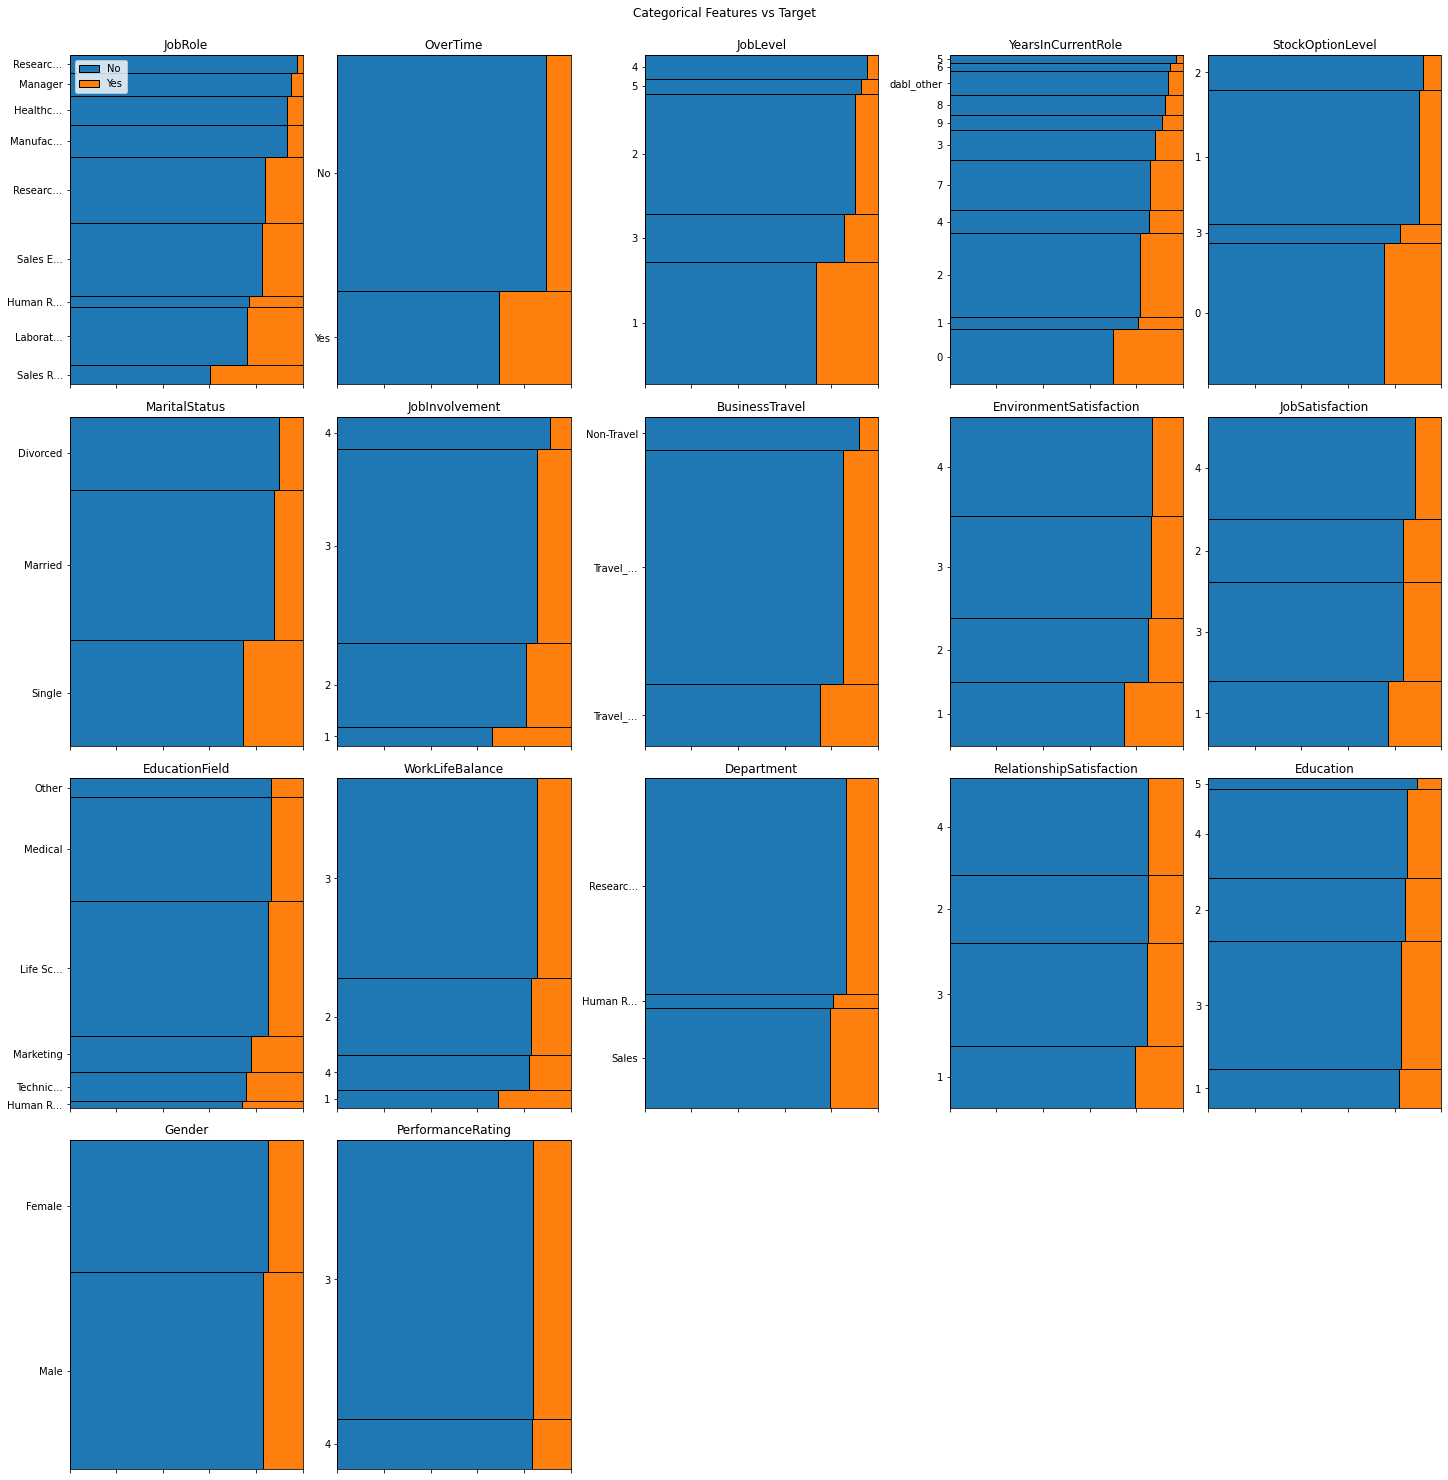

In [ ]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
db.plot(hr_data, y = "Attrition", 
        type_hints = {"DistanceFromHome" : "continuous",
                      "EmployeeCount" : "continuous",
                      "HourlyRate" : "continuous",
                      "MonthlyRate" : "continuous", 
                      "NumCompaniesWorked" : "continuous", 
                      "PercentSalaryHike" : "continuous",
                      "StandardHours" : "continuous", 
                      "TotalWorkingYears" : "continuous", 
                      "YearsAtCompany" : "continuous",
                      "YearsSinceLastPromotion" : "continuous",
                      "YearsWithCurrManager" : "continuous", 
                      "TrainingTimesLastYear" : "continuous",
                      "Age" : "continuous",
                      "DailyRate" : "continuous",
                      "MonthlyIncome" : "continuous"})

In [ ]:
# Create different features to feed into pycaret setup
target = "Attrition"

cont_feats = ["DistanceFromHome", "HourlyRate",  "DailyRate", "MonthlyIncome",
              "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike",
              "TotalWorkingYears", "YearsAtCompany",
              "YearsWithCurrManager", "TrainingTimesLastYear", "YearsSinceLastPromotion"]

ord_feats = {"StockOptionLevel" : ["0", "1", "2", "3"],
             "EnvironmentSatisfaction" : ["1", "2", "3", "4"],
             "JobInvolvement" : ["1", "2", "3", "4"],
             "JobSatisfaction" : ["1", "2", "3", "4"],
             "Education" : ["1", "2", "3", "4", "5"],
             "PerformanceRating" : ["3", "4"],
             "RelationshipSatisfaction" : ["1", "2", "3", "4"],
             "WorkLifeBalance" : ["1", "2", "3", "4"]}

cat_feats = ["BusinessTravel", "Department", "EducationField", "JobRole",
             "Gender", "JobLevel", "JobRole", "Over18",
             "MaritalStatus", "OverTime", "WorkLifeBalance"]

ignore = ["EmployeeNumber", "StandardHours", "EmployeeCount"]

In [ ]:
# Insert synthetic data into real dataset and randomly split it
hr_data["dataset"] = "real"
synth_data["dataset"] = "synth"

full_data = pd.concat([hr_data, synth_data])

X_train, X_test, y_train, y_test = train_test_split(hr_data.drop("Attrition", axis = 1), hr_data["Attrition"], test_size=0.33, random_state=42)

X_train["Attrition"] = y_train
X_test["Attrition"] = y_test

input = pd.concat([X_train, synth_data]).drop("dataset", axis = 1)
test = X_test.drop("dataset", axis = 1)

In [ ]:
# Run pycaret setup
setup(input, target = target, test_data = test,
      train_size = 0.75,
      transformation = True, pca = True,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "maxabs",
      data_split_stratify = True,
      silent = True)

,Description,Value
0,session_id,6136
1,Target,Attrition
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(1234, 35)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,17
8,Ordinal Features,True
9,High Cardinality Features,False


({'Bagging': <pycaret.containers.models.classification.BaggingClassifierContainer at 0x7f2942529240>,
  'CalibratedCV': <pycaret.containers.models.classification.CalibratedClassifierCVContainer at 0x7f2942528f28>,
  'Stacking': <pycaret.containers.models.classification.StackingClassifierContainer at 0x7f29425290f0>,
  'Voting': <pycaret.containers.models.classification.VotingClassifierContainer at 0x7f29425290b8>,
  'ada': <pycaret.containers.models.classification.AdaBoostClassifierContainer at 0x7f29424edda0>,
  'catboost': <pycaret.containers.models.classification.CatBoostClassifierContainer at 0x7f29425295c0>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7f29424ed9b0>,
  'et': <pycaret.containers.models.classification.ExtraTreesClassifierContainer at 0x7f2942529b38>,
  'gbc': <pycaret.containers.models.classification.GradientBoostingClassifierContainer at 0x7f29424ede80>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClas

In [ ]:
top = compare_models(sort = "AUC", n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8291,0.8892,0.6869,0.7906,0.7214,0.6017,0.6146,0.022
catboost,CatBoost Classifier,0.8317,0.8882,0.5912,0.8720,0.6848,0.5828,0.6129,8.346
lda,Linear Discriminant Analysis,0.8275,0.8857,0.6679,0.8011,0.7104,0.5930,0.6100,0.021
et,Extra Trees Classifier,0.7896,0.8816,0.3946,0.9333,0.5287,0.4392,0.5080,0.491
lightgbm,Light Gradient Boosting Machine,0.8317,0.8808,0.6296,0.8296,0.6993,0.5912,0.6111,0.313
qda,Quadratic Discriminant Analysis,0.8284,0.8790,0.7447,0.7450,0.7320,0.6082,0.6192,0.017
xgboost,Extreme Gradient Boosting,0.8179,0.8780,0.6175,0.7937,0.6798,0.5609,0.5770,1.583
rf,Random Forest Classifier,0.8082,0.8761,0.5074,0.8609,0.6185,0.5123,0.5507,0.722
gbc,Gradient Boosting Classifier,0.8163,0.8732,0.5840,0.8132,0.6621,0.5482,0.5704,0.849
ada,Ada Boost Classifier,0.8121,0.8710,0.6484,0.7604,0.6881,0.5582,0.5695,0.244


In [ ]:
blend_models(top, optimize = "AUC")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7823,0.8110,0.4286,0.8571,0.5714,0.4464,0.4946
1,0.7742,0.8301,0.4048,0.8500,0.5484,0.4221,0.4738
2,0.7984,0.8359,0.4524,0.9048,0.6032,0.4874,0.5401
3,0.8145,0.9106,0.5476,0.8519,0.6667,0.5464,0.5720
4,0.8455,0.9280,0.7143,0.8108,0.7595,0.6464,0.6492
5,0.8780,0.9292,0.7857,0.8462,0.8148,0.7241,0.7252
6,0.8699,0.9171,0.7857,0.8250,0.8049,0.7074,0.7079
7,0.8699,0.9250,0.8293,0.7907,0.8095,0.7108,0.7113
8,0.8699,0.9438,0.8293,0.7907,0.8095,0.7108,0.7113
9,0.8699,0.9488,0.8780,0.7660,0.8182,0.7176,0.7217


TunableVotingClassifier(estimators=[('lr',
                                     LogisticRegression(C=1.0,
                                                        class_weight=None,
                                                        dual=False,
                                                        fit_intercept=True,
                                                        intercept_scaling=1,
                                                        l1_ratio=None,
                                                        max_iter=1000,
                                                        multi_class='auto',
                                                        n_jobs=None,
                                                        penalty='l2',
                                                        random_state=6136,
                                                        solver='lbfgs',
                                                        tol=0.0001, verbose=0,
               

In [ ]:
unseen_results = predict_model(lr, data = test.drop("Attrition", axis = 1))

In [ ]:
unseen_results["actual"] = test["Attrition"]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score

recall_score(unseen_results["actual"], unseen_results["Label"], labels = ["Yes", "No"], pos_label = "No")

0.9038461538461539

# FASTAI

In [ ]:
X = get_config("X")
Y = get_config("y")
X["target"] = Y

In [ ]:
from fastai.tabular.all import *

ModuleNotFoundError: ignored

In [ ]:
cat, cont = cont_cat_split(X, dep_var = "target")
splits = RandomSplitter()(range_of(X))

In [ ]:
X['target'] = X['target'].astype(str)

In [ ]:
to = TabularPandas(X, procs = [Categorify, Normalize], cat_names = cat, cont_names = cont, 
                   y_names = "target", splits = splits, y_block = CategoryBlock())

In [ ]:
dls = to.dataloaders(bs = 6)

In [ ]:
del learn

In [ ]:
learn = tabular_learner(dls, metrics = [accuracy, RocAucBinary(), Precision(), Recall()])

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.3019951581954956)

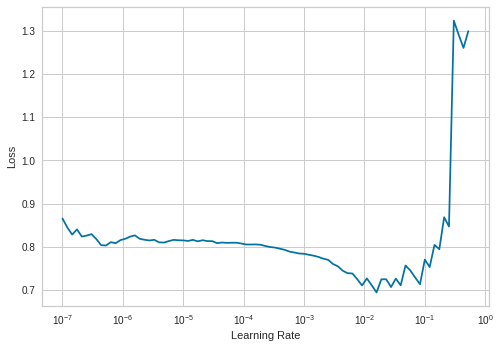

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,precision_score,recall_score,time
0,0.465865,0.776532,0.830508,0.497449,0.000000,0.000000,00:04


epoch,train_loss,valid_loss,accuracy,roc_auc_score,precision_score,recall_score,time
0,0.323373,0.628975,0.830508,0.497449,0.000000,0.000000,00:04
1,0.212172,0.593734,0.830508,0.502551,0.000000,0.000000,00:04
2,0.205524,0.914700,0.830508,0.497449,0.000000,0.000000,00:04
3,0.190716,0.780756,0.830508,0.502551,0.000000,0.000000,00:04
4,0.167379,0.955354,0.830508,0.502551,0.000000,0.000000,00:04
5,0.095870,0.966577,0.830508,0.502551,0.000000,0.000000,00:04
6,0.040892,1.393632,0.830508,0.502551,0.000000,0.000000,00:04
7,0.021438,1.204639,0.830508,0.502551,0.000000,0.000000,00:04
8,0.017399,1.349500,0.830508,0.502551,0.000000,0.000000,00:04
9,0.004320,1.310108,0.830508,0.502551,0.000000,0.000000,00:04
